In [10]:
import pickle as pkl
import numpy as np

X = pkl.load(open('./data/X_processed.pkl', 'rb'))
y = pkl.load(open('./data/y_processed.pkl', 'rb'))

print(X.shape, y.shape)

((6502, 3, 12), (6502,))


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

training_size = 6000

X_train = X[:training_size]
y_train = y[:training_size]

X_test = X[training_size:]
y_test = y[training_size:]

X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.92031872509960155

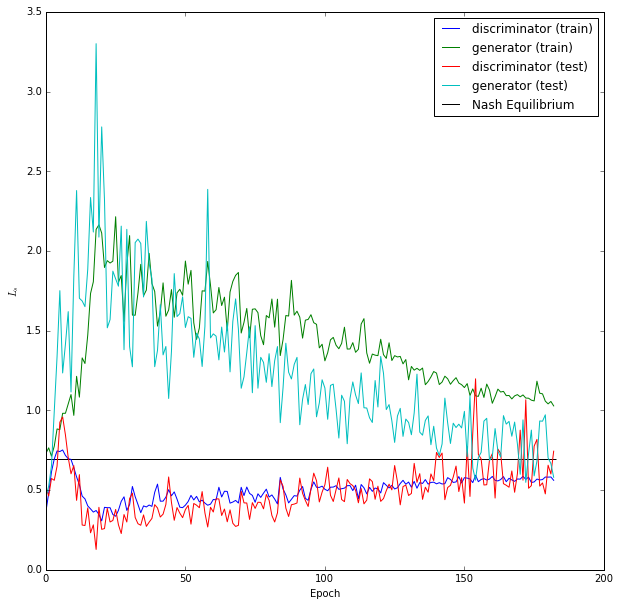

In [12]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.figure(figsize=(10,10))

hist = pkl.load(open('./output/params/acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')

plt.show()

In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

acgan = __import__('ac_gan')

from glob import glob
from keras.models import load_model

directory = './output/params/'

latent_size = 100

gen_name = sorted(glob(directory + 'params_generator*'))[-1]
print(gen_name)
g = load_model(gen_name)

./output/params/params_generator_epoch_182.h5


In [14]:
generate_count = training_size

noise = np.random.uniform(-1, 1, (generate_count, latent_size))
sampled_labels = np.random.randint(0, 2, generate_count)
generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

print(generated_images.shape)
gen_X_train = np.reshape(generated_images, (training_size, 3, 12))

print(np.max(gen_X_train))

for i in range(gen_X_train.shape[0]):
    gen_X_train[i][0] = gen_X_train[i][0] 
    gen_X_train[i][1] = gen_X_train[i][1] 
    gen_X_train[i][2] = gen_X_train[i][2]

gen_X_train = gen_X_train.astype(int)
print(gen_X_train[:2])
print(gen_X_train.shape)

gen_X_train = gen_X_train.reshape(generate_count, -1)
print(gen_X_train.shape)

gen_y_train = sampled_labels

unique, counts = np.unique(y_train, return_counts=True)
print('real' + str(dict(zip(unique, counts))))

unique, counts = np.unique(gen_y_train, return_counts=True)
print('gen' + str(dict(zip(unique, counts))))

print(gen_X_train.shape)

print(gen_y_train.shape)

(6000, 1, 3, 12)
208.356
[[[ 80  77  75  75  77  76  81  80  85  83  89  84]
  [ 45  43  41  40  43  44  46  46  50  47  47  49]
  [  1   1   0   0   1   0   0   0   0   0   0   0]]

 [[132 140 125 121 122 124 118 126 141 129 129 126]
  [ 84  89  84  73  71  77  69  73  85  69  73  72]
  [  4   2   3   2   2   2   0   1   2   2   1   2]]]
(6000, 3, 12)
(6000, 36)
real{0: 2981, 1: 3019}
gen{0: 2962, 1: 3038}
(6000, 36)
(6000,)


# Transfer Learning

In [15]:
gen_y_pred = classifier.fit(gen_X_train, gen_y_train).predict(X_test)
accuracy_score(y_test, gen_y_pred)

0.50796812749003983

# Real vs. Fake

In [16]:
from sklearn.model_selection import cross_val_score

clf =  RandomForestClassifier()

X_comb = np.concatenate((gen_X_train, X_train))
y = np.array([1] * generate_count + [0] * training_size)

print(X_comb.shape, y.shape)
scores = cross_val_score(clf, X_comb, y, cv=5)
print(scores)

from sklearn.neighbors import KNeighborsClassifier
nn_clf = KNeighborsClassifier(n_neighbors=9)

scores = cross_val_score(nn_clf, X_comb, y, cv=5)
print(scores)

((12000, 36), (12000,))
[ 0.99166667  0.98666667  0.98291667  0.98791667  0.98458333]
[ 0.92        0.92625     0.92625     0.92166667  0.93625   ]


# PCA plot

(12000, 36)


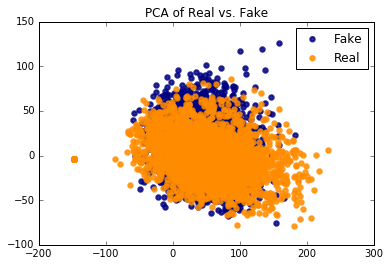

In [17]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_pca = np.concatenate((gen_X_train, X_train))
print(X_pca.shape)

y = np.array([1] * generate_count + [0] * training_size)

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')

(1000, 36)


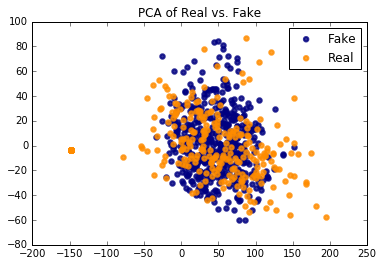

In [18]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plot_count = 500
X_pca = np.concatenate((gen_X_train[:plot_count], X_train[:plot_count]))
print(X_pca.shape)

y = np.array([1] * plot_count + [0] * plot_count)

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')